In [1]:
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy

import sklearn.calibration as calibration
import mapie.metrics as mapie_metrics
import sklearn.metrics as metrics
from sklearn.calibration import CalibrationDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from analysis import *
from analysis import calibration_name_convert, metric_name_convert, model_name_convert

In [2]:
def cal_metric(y_true, prob_results, model_names=['LogisticRegression', 'SVM', 'XGBoost', 'RandomForest'], metric='ece'):
    all_result = {}

    for i, model_name in enumerate(model_names):
        all_result[model_name] = {}
        for key, value in prob_results.items():

            if model_name.lower() not in key.lower():
                continue
            prob = np.array(value)

            pred = prob.argmax(axis=1)
            class_0 = np.zeros_like(y_true)
            class_0[pred == 0] = 1

            # this should be adaptive calibration error
            if metric == 'ece':
                ece_0 = mapie_metrics.expected_calibration_error(
                    class_0, prob[:, 0], num_bins=10, split_strategy='quantile')
                ece_1 = mapie_metrics.expected_calibration_error(
                    y_true, prob[:, 1], num_bins=10, split_strategy='quantile')
                results = (ece_0 + ece_1)/2
            elif metric == 'acc':
                results = metrics.accuracy_score(y_true, pred)
            elif metric == 'auroc':
                results = metrics.roc_auc_score(y_true, prob[:, 1])
            elif metric == 'auprc':
                precision, recall, threshold = metrics.precision_recall_curve(
                    y_true, prob[:, 1])
                results = metrics.auc(recall, precision)

            all_result[model_name][key] = results
    return all_result




def plot_curve_all(y_true, prob_results, start=0, model_names=['LogisticRegression', 'SVM', 'XGBoost', 'RandomForest']):
    all_plot = {}

    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i, model_name in enumerate(model_names):
        all_plot[model_name] = {}
        j = start
        for key, value in prob_results.items():

            if model_name.lower() != key.split('_')[0].lower():
                continue
            if len(key.split('_')) == 2:
                if key.split('_')[1] == 'conformal':
                    continue

            prob = np.array(value)

            disp = CalibrationDisplay.from_predictions(
                y_true, prob[:, 1], ax=ax[i][j], strategy='quantile', n_bins=10)
            ax[i][j].set_xlabel(None)
            ax[i][j].set_ylabel(None)

            if j == 0:
                ax[i][j].set_ylabel(model_name)
            if i == 0:

                if len(key.split('_')) >= 2:

                    title = key.split('_')[1]

                    if title == 'sigmoid':
                        title = 'PS'
                    elif title == 'isotonic':
                        title = 'IR'
                    elif title == 'venn':
                        title = 'VAs'
                else:
                    title ='UC'
                ax[i][j].set_title(title)
            # ax[i][j].tick_params(axis='both', which='both', length=0)
            j += 1
    fig.tight_layout()
    plt.savefig('results_paper/calibration_curve.png', dpi = 800)
    return all_plot

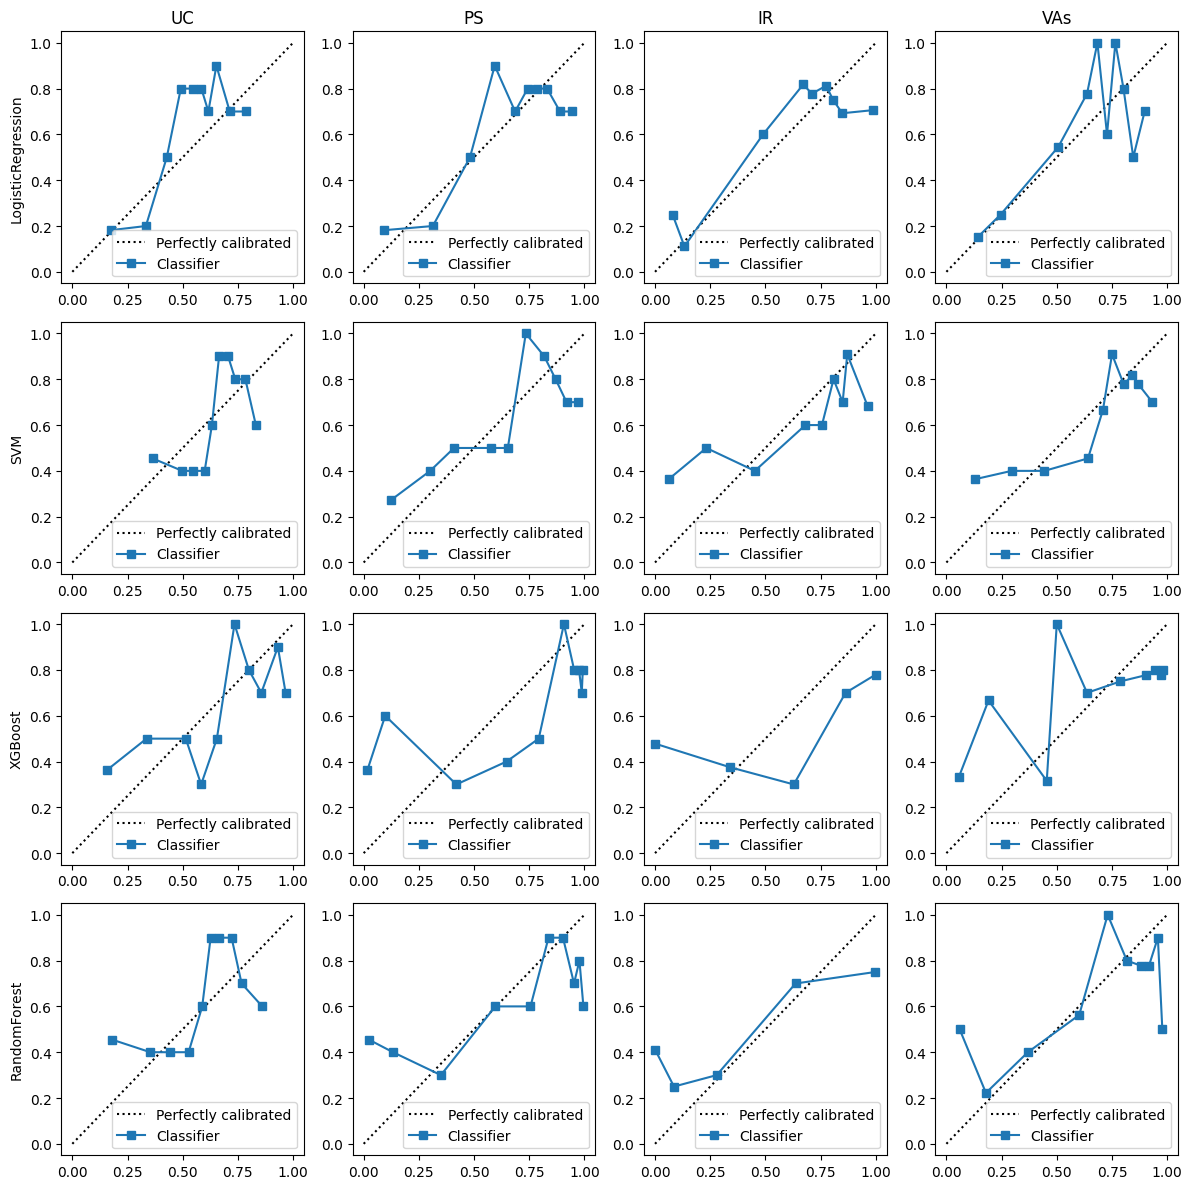

In [3]:
suffix = '_eso_noclinical'
training_folder = 'training_results_paper'
save_folder = 'results_paper'

with open(f'{training_folder}/loo_trained_models{suffix}.pkl', 'rb') as f:
    models = pickle.load(f)
# Load the data
with open(f'{training_folder}/loo_data_results{suffix}.pkl', 'rb') as f:
    datasets = pickle.load(f)

with open(f'{training_folder}/loo_prob_results{suffix}.pkl', 'rb') as f:
    prob_results = pickle.load(f)

y_true = []
for key, value in datasets.items():
    y_true.append(value['y_test'])
y_true  = np.array(y_true)
y_true = y_true.reshape(-1)


dose_radiomic_ece = cal_metric(y_true, prob_results, metric = 'ece')
dose_radiomic_acc = cal_metric(y_true, prob_results, metric = 'acc')
dose_radiomic_auroc = cal_metric(y_true, prob_results, metric = 'auroc')
dose_radiomic_auprc = cal_metric(y_true, prob_results, metric = 'auprc')

###########################
plot_curve_all(y_true, prob_results, start = 0)
plt.show()



###############################################
suffix = '_eso_dose'

with open(f'{training_folder}/loo_trained_models{suffix}.pkl', 'rb') as f:
    models = pickle.load(f)

# Load the data
with open(f'{training_folder}/loo_data_results{suffix}.pkl', 'rb') as f:
    datasets = pickle.load(f)

with open(f'{training_folder}/loo_prob_results{suffix}.pkl', 'rb') as f:
    prob_results = pickle.load(f)

y_true = []
for key, value in datasets.items():
    y_true.append(value['y_test'])
y_true  = np.array(y_true)
y_true = y_true.reshape(-1)

dose_ece = cal_metric(y_true, prob_results)
dose_acc = cal_metric(y_true, prob_results, metric = 'acc')
dose_auroc = cal_metric(y_true, prob_results, metric = 'auroc')
dose_auprc = cal_metric(y_true, prob_results, metric = 'auprc')


###############################################
suffix = '_eso_dosimetric'

with open(f'{training_folder}/loo_trained_models{suffix}.pkl', 'rb') as f:
    models = pickle.load(f)

# Load the data
with open(f'{training_folder}/loo_data_results{suffix}.pkl', 'rb') as f:
    datasets = pickle.load(f)

with open(f'{training_folder}/loo_prob_results{suffix}.pkl', 'rb') as f:
    prob_results = pickle.load(f)

y_true = []
for key, value in datasets.items():
    y_true.append(value['y_test'])
y_true  = np.array(y_true)
y_true = y_true.reshape(-1)

dosimetric_ece = cal_metric(y_true, prob_results)
dosimetric_acc = cal_metric(y_true, prob_results, metric = 'acc')
dosimetric_auroc = cal_metric(y_true, prob_results, metric = 'auroc')
dosimetric_auprc = cal_metric(y_true, prob_results, metric = 'auprc')



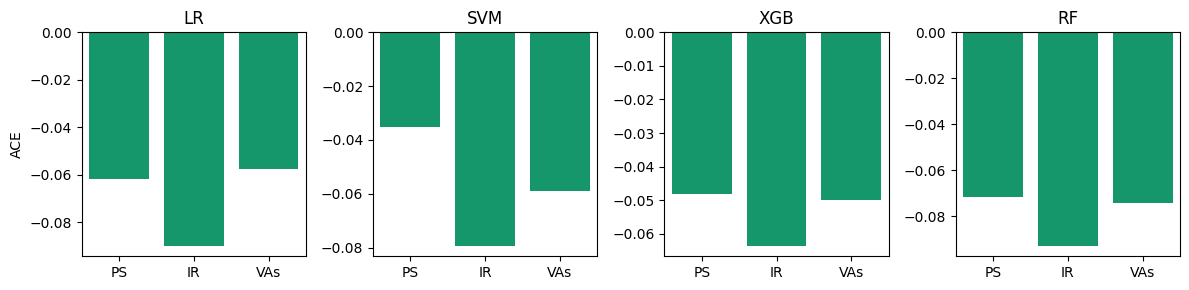

In [4]:
df = None
all_ace_df = []
for key, value in dose_radiomic_ece.items():
    if df is None:
        df = pd.DataFrame(value, index=['ACE']).T
        df = df-df.iloc[0]
        df = df.drop(index = df.index[0])
        df = df.drop(index = df.index[-1])
        all_ace_df.append(df)
    else:
        tmp_df = pd.DataFrame(value, index=['ACE']).T
        tmp_df = tmp_df-tmp_df.iloc[0]
        tmp_df = tmp_df.drop(index = tmp_df.index[0])
        tmp_df = tmp_df.drop(index = tmp_df.index[-1])
        all_ace_df.append(tmp_df)

#######################################

fig, axs = plt.subplots(1,4, figsize=(12, 3))

for i, ace_df in enumerate(all_ace_df):

    labels = [calibration_name_convert["_".join(i.split('_')[1:])] for i in ace_df.index]
    colors = ['#00ab72' if ace_df['ACE'][i] < 0 else '#b53d1b' for i in range(len(ace_df['ACE']))]
    axs.flat[i] = sns.barplot(x=labels, y=ace_df['ACE'], ax = axs.flat[i], palette = colors, width=0.8)
    if i != 0:
        axs.flat[i].set_ylabel("")
    axs.flat[i].set_title(model_name_convert[f'{ace_df.index[0].split("_")[0]}'])

fig.tight_layout()
plt.savefig(f'{save_folder}/different_after_vs_before_calibrated.png', dpi = 800)

In [5]:
ece_results = {}

for key in dose_ece.keys():
    ece_results[key] = dose_radiomic_ece[key][key]- dose_ece[key][key]
ece_df = pd.DataFrame(ece_results, index = ['ACE']).T
results_df = ece_df

ece_results = {}
for key in dose_acc.keys():
    ece_results[key] = dose_radiomic_acc[key][key]- dose_acc[key][key]
bacc_df = pd.DataFrame(ece_results, index = ['ACC']).T

results_df = pd.concat([results_df, bacc_df], axis = 1)

ece_results = {}
for key in dose_auroc.keys():
    ece_results[key] = dose_radiomic_auroc[key][key]- dose_auroc[key][key]
auroc_df = pd.DataFrame(ece_results, index = ['AUROC']).T
results_df = pd.concat([results_df, auroc_df], axis = 1)

ece_results = {}
for key in dose_auprc.keys():
    ece_results[key] = dose_radiomic_auprc[key][key]- dose_auprc[key][key]
auprc_df = pd.DataFrame(ece_results, index = ['AUPRC']).T
results_df = pd.concat([results_df, auprc_df], axis = 1)

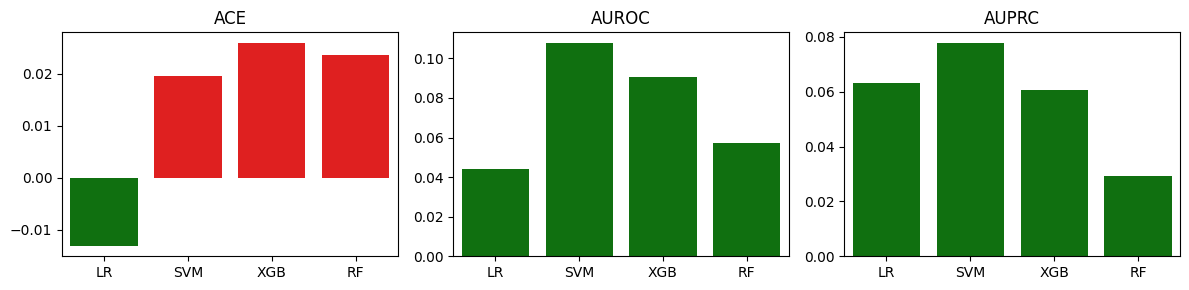

In [6]:
x_labels = ['ACE', 'AUROC', 'AUPRC']

fig, axs = plt.subplots(1,len(x_labels), figsize=(12, 3))

labels = [model_name_convert[i] for i in results_df.index]

minus = 0
for i, col in enumerate(results_df.columns):

    if col not in x_labels:

        minus-=1
        continue
    if col == 'ACE':
        colors = ['green' if x < 0 else 'red' for x in results_df[col]]
    else:
        colors = ['green' if x > 0 else 'red' for x in results_df[col]]

    axs.flat[i+minus] = sns.barplot(x = labels, y = results_df[col], ax = axs.flat[i+minus], palette = colors)
    axs.flat[i+minus].set_title(x_labels[i+minus], color='black')
    axs.flat[i+minus].set_ylabel('', color='black')
    axs.flat[i+minus].tick_params(axis='both', colors='black')
fig.tight_layout()
plt.savefig(f'{save_folder}/different_all_vs_dose.png', dpi = 800)

In [1]:
import pandas as pd
import numpy as np

In [62]:
df = pd.read_csv(r'results_paper\coverage_threshold_eso_noclinical.csv', index_col=[0,1], header=[0,1])

new_df = pd.DataFrame(columns = df.columns, index = df.index)
for index in df.index:
    if 'UC' in index[1]:
        new_df.loc[index] = df.loc[index].round(2)
        continue

    results = df.loc[index] - df.loc[index[0], 'UC'].replace(np.nan, 0)
    for i, value in enumerate(results.round(2)):
        results.iloc[i] = f"+{np.round(value, 2)}" if value > 0 else f"{np.round(value, 2)}"
    new_df.loc[index] = results

new_df = new_df.astype(str)
new_df.to_csv(r'results_paper\coverage_threshold_eso_noclinical_process.csv')

C:\Users\dream\AppData\Local\Temp\ipykernel_13728\264653204.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results.iloc[i] = f"+{np.round(value, 2)}" if value > 0 else f"{np.round(value, 2)}"
